# GPT-2 Fine-Tuning on MedQuad + iCliniq




## Setup

In [1]:
import torch

In [2]:
torch.cuda.empty_cache() #free GPU space

In [3]:
!ls

 Copy_of_BERT_Classifier.ipynb	 model_moi_big
 dataset2.csv			 models
 GPT2_v2-Copy1.ipynb		 models1
 GPT2_v2-Copy2.ipynb		 new_dataset.csv
 GPT2_v2.ipynb			 new_dataset_fused_tested_on_icliniq.csv
 GPT_Classification.ipynb	 new_dataset_fused_tested_on_medquad_big.csv
'GPT Medquad+icliniq.ipynb'	 new_dataset_fused_tested_on_medquad.csv
'GPT Medquad+icliniq.py'	 new_dataset_tested1.csv
 inferenceBG_general.py		 new_dataset_tested.csv
 __MACOSX			 nltk_data
 medquad.csv			 output.txt
 MedQuAD-master			 predicted.csv
 MedQuAD-master.zip		 test.csv
 model_moi			 train.csv


In [4]:
import os                   # Operating system-related functionalities
import json                 # Working with JSON data
import time                 # Handling time-related operations
import datetime             # Handling date and time
import pandas as pd         # Data analysis
import seaborn as sns       # Data visualization
import numpy as np          # Numerical computations
import random               # Generating random numbers

import matplotlib.pyplot as plt   # Data visualization

# %matplotlib inline  # This is a magic command used in Jupyter notebooks for inline plotting

import torch                            # Deep learning framework
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)                    # Setting a seed for reproducibility

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup  # NLP and pre-trained models

import nltk
nltk.download('punkt')  # Downloading the 'punkt' package from NLTK for tokenization


2023-06-04 00:10:18.329577: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-04 00:10:18.384628: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 00:10:19.134465: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package punkt to /home/nyagnik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Create Training Set

In [5]:
df_whole = pd.read_csv('dataset2.csv') #read icliniq 
df_whole.head()

,Unnamed: 0,Question,Answer
0,0,my 5 1/2-year-old son displays adhd symptoms f...,adhd and bipolar mood disorder (bmd) can coexi...
1,1,my son has add and mild autism. he has been su...,stimulants in general tend to decrease appetit...
2,2,my son is 13 and is depressed. he has been tak...,while any of the stimulant medications can inc...
3,3,my 17-year-old has stopped taking concerta aft...,seventy percent of teens diagnosed when they a...
4,4,i've been taking respa-ar for allergies. i can...,try claritin-d which is located behind the pha...


In [6]:
df_whole.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29752 entries, 0 to 29751
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  29752 non-null  int64 
 1   Question    29752 non-null  object
 2   Answer      29752 non-null  object
dtypes: int64(1), object(2)
memory usage: 697.4+ KB


In [7]:
from sklearn.utils import shuffle

# Assuming your DataFrame is called "df"
# Assuming you want to split the dataset into 70% for training and 30% for testing

# Set the random seed for reproducibility
random_seed = 42

# Shuffle the DataFrame rows randomly
df_whole = shuffle(df_whole, random_state=random_seed)

# Calculate the index to split the dataset
split_index = int(len(df_whole) * 0.9)

# Split the dataset into training and test sets
df = df_whole.iloc[:split_index]
test = df_whole.iloc[split_index:]
#split into train test split

In [8]:
df_2 = pd.read_csv('medquad.csv') #read medquad
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16402 entries, 0 to 16401
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  16402 non-null  int64 
 1   Questions   16402 non-null  object
 2   Answers     16402 non-null  object
 3   Focus       16388 non-null  object
dtypes: int64(1), object(3)
memory usage: 512.7+ KB


In [9]:
df_2 = df_2.rename(columns={'Questions': 'Question', 'Answers': 'Answer'})

In [10]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16402 entries, 0 to 16401
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  16402 non-null  int64 
 1   Question    16402 non-null  object
 2   Answer      16402 non-null  object
 3   Focus       16388 non-null  object
dtypes: int64(1), object(3)
memory usage: 512.7+ KB


In [11]:
frame = [df,df_2]

In [12]:
df = pd.concat(frame,ignore_index = True) #concat the two dataframes

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43178 entries, 0 to 43177
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  43178 non-null  int64 
 1   Question    43178 non-null  object
 2   Answer      43178 non-null  object
 3   Focus       16388 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.3+ MB


In [14]:
df.drop(['Focus'],inplace=True, axis = 1)

In [16]:
df.head()

,Unnamed: 0,Question,Answer
0,25881,my 13 year old daughter has been having a shoo...,i’d rather not worry you further and i’m no do...
1,15938,what is paget's disease?,paget's disease is a long-lasting (chronic) co...
2,6334,can a person get tonsilitis if they nolonger h...,i will never understand that rationale of givi...
3,10901,can the common cold make your teeth hurt with ...,i guess that would be neurologically possible ...
4,26856,bleeding from anus blood in urine pain in lowe...,if the bleeding from anus is fresh red colored...


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43178 entries, 0 to 43177
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  43178 non-null  int64 
 1   Question    43178 non-null  object
 2   Answer      43178 non-null  object
dtypes: int64(1), object(2)
memory usage: 1012.1+ KB


In [18]:
# Clean Data
df['Question'] = df['Question'].astype(str)
df['Answer'] = df['Answer'].astype(str)
#df['summary'] = df['summary'].astype(str)

# drop NA's
df = df.dropna()
df.head()

,Unnamed: 0,Question,Answer
0,25881,my 13 year old daughter has been having a shoo...,i’d rather not worry you further and i’m no do...
1,15938,what is paget's disease?,paget's disease is a long-lasting (chronic) co...
2,6334,can a person get tonsilitis if they nolonger h...,i will never understand that rationale of givi...
3,10901,can the common cold make your teeth hurt with ...,i guess that would be neurologically possible ...
4,26856,bleeding from anus blood in urine pain in lowe...,if the bleeding from anus is fresh red colored...


In [19]:
# Add marker
df['Question'] = '[WP]' + df['Question'] # + '?'
df['Answer'] = '\n[RESPONSE]' + df['Answer']
df.head()

,Unnamed: 0,Question,Answer
0,25881,[WP]my 13 year old daughter has been having a ...,\n[RESPONSE]i’d rather not worry you further a...
1,15938,[WP]what is paget's disease?,\n[RESPONSE]paget's disease is a long-lasting ...
2,6334,[WP]can a person get tonsilitis if they nolong...,\n[RESPONSE]i will never understand that ratio...
3,10901,[WP]can the common cold make your teeth hurt w...,\n[RESPONSE]i guess that would be neurological...
4,26856,[WP]bleeding from anus blood in urine pain in ...,\n[RESPONSE]if the bleeding from anus is fresh...


In [20]:
len(df)

43178

In [21]:
# Define a function to count the number of words in a string
def count_words(text):
    return len(text.split())

# Create a boolean mask indicating which rows have more than 300 words
mask = df['Answer'].apply(count_words) > 300

# Filter out the rows with more than 300 words
df_new = df.loc[~mask]

In [22]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39550 entries, 0 to 43177
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  39550 non-null  int64 
 1   Question    39550 non-null  object
 2   Answer      39550 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [23]:
# merge into one
qa_pair = df_new["Question"] + df_new["Answer"] # \n vs ' ' ???

qa_pair.head()

0    [WP]my 13 year old daughter has been having a ...
1    [WP]what is paget's disease?\n[RESPONSE]paget'...
3    [WP]can the common cold make your teeth hurt w...
4    [WP]bleeding from anus blood in urine pain in ...
5    [WP]what is chickenpox?\n[RESPONSE]chickenpox ...
dtype: object

In [24]:
small_sample = qa_pairhowtos.sample(300)

In [25]:
replace_dict = {'[WP]': '!'}
#small_sample = pd.Series(small_sample)
small_sample.str.replace('"', '').str.replace('\n,\n', '').str.replace('``', '').str.replace(',,', ',')

373      [WP]just went off birth control instead of per...
43053    [WP]What are the treatments for Parasites - Fa...
25328    [WP]are acidity and constipation the withdrawa...
24405    [WP]58 year old experiencing pressure and a he...
12903    [WP]my son has a rash all over his body that l...
                               ...                        
4886     [WP]which cosmetic filler is best for me?\n[RE...
21541    [WP]is it safe to take st. john’s wort while t...
33691    [WP]What is (are) Pyelonephritis: Kidney Infec...
36778    [WP]Is congenital diaphragmatic hernia inherit...
13380    [WP]my 4 month old has red raw skin around her...
Length: 300, dtype: object

In [26]:
def clean_text(text):
    #text = text.replace('\n','')
    text = text.replace('``', '')
    text = text.replace('"', '')
    text = text.replace("\n,\n", "").replace(".,", ".").replace('"', '').replace('\n','')
    text = text.replace(" ,", ",").replace(" .", ".").replace(" %", "%")
    text = text.replace(" - ", "-").replace(" : ", ":").replace(" / ", "/")
    text = text.replace("( ", "(").replace(" )", ")")
    #text = text.replace("`` ", "\"").replace(" ''", "\"")
    text = text.replace(" 's", "'s").replace("s ' ", "s' ")
    return text

### check length

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

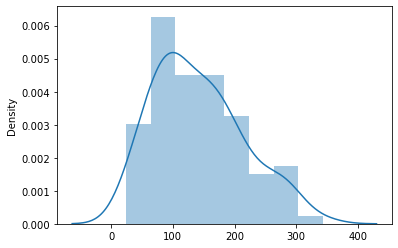

In [27]:
doc_lengths = []

for howto in qa_pair.sample(n=100):

    # get rough token count distribution
    tokens = nltk.word_tokenize(howto)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [29]:
np.average(doc_lengths)

141.67

# GPT2 Tokenizer

In [30]:
# NOTE: EMBEDDING SIZE NOT LARGE ENOUGH!!! -- SHOULD USE LARGER MODEL
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# PyTorch Datasets & Dataloaders


Testing I managed to run it in 4 using Paperspace PRO machines

In [31]:
batch_size = 2

In [32]:
def clean_text(text):
    text = text.replace('\n\n\n\n','\n').replace('\n\n\n','\n').replace('\n ','\n')
    text = text.replace('``', '').replace('.;', '.')
    text = text.replace('"', '').replace("\n,", "").replace("\n, ", "")
    text = text.replace("\n,\n", "").replace(".,", ".").replace('"', '').replace('\n;\n','')
    text = text.replace(" ,", ",").replace(" .", ".").replace(" %", "%")
    text = text.replace(" - ", "-").replace(" : ", ":").replace(" / ", "/")
    text = text.replace("( ", "(").replace(" )", ")")
    #text = text.replace("`` ", "\"").replace(" ''", "\"")
    text = text.replace(" 's", "'s").replace("s ' ", "s' ")
    return text
    
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="distilgpt2", max_length=1024):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:
    
      text = txt #= clean_text(txt)
      encodings_dict = tokenizer('<|startoftext|>'+ text + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [33]:
dataset = GPT2Dataset(qa_pair, tokenizer, max_length=512)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

31,640 training samples
7,910 validation samples


In [34]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Fine-tune

In [35]:
configuration = GPT2Config.from_pretrained('distilgpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("distilgpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [36]:
# some parameters I cooked up that work reasonably well
epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8
check_path = './checkpoints'



# this produces sample output every 100 steps
sample_every = 100

In [37]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )
# checkpoint
#torch.save({
#            'epoch': epochs,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': LOSS,
#            }, check_path)

/home/nyagnik/.local/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [38]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [39]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [40]:
torch.cuda.empty_cache()

### Training

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate( # print examples of generated outputs
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
#            for i, sample_output in enumerate(sample_outputs):
#                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 6 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  15,820. Loss: 1.9762693643569946.   Elapsed: 0:00:08.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  15,820. Loss: 1.5662312507629395.   Elapsed: 0:00:18.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  15,820. Loss: 1.8938050270080566.   Elapsed: 0:00:27.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  15,820. Loss: 0.916754424571991.   Elapsed: 0:00:36.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  15,820. Loss: 0.8765288591384888.   Elapsed: 0:00:45.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  15,820. Loss: 1.5097161531448364.   Elapsed: 0:00:55.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  15,820. Loss: 0.986992597579956.   Elapsed: 0:01:04.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  15,820. Loss: 0.6342055201530457.   Elapsed: 0:01:13.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  15,820. Loss: 0.5720718502998352.   Elapsed: 0:01:22.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  15,820. Loss: 1.2247201204299927.   Elapsed: 0:01:31.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  15,820. Loss: 0.9811091423034668.   Elapsed: 0:01:41.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  15,820. Loss: 1.1514962911605835.   Elapsed: 0:01:50.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  15,820. Loss: 1.6523491144180298.   Elapsed: 0:02:00.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  15,820. Loss: 0.48175615072250366.   Elapsed: 0:02:10.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  15,820. Loss: 1.3863309621810913.   Elapsed: 0:02:19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  15,820. Loss: 0.46272793412208557.   Elapsed: 0:02:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  15,820. Loss: 0.684763491153717.   Elapsed: 0:02:39.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  15,820. Loss: 0.4317367970943451.   Elapsed: 0:02:49.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  15,820. Loss: 1.3733702898025513.   Elapsed: 0:03:00.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  15,820. Loss: 1.308424711227417.   Elapsed: 0:03:09.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  15,820. Loss: 1.4942600727081299.   Elapsed: 0:03:19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  15,820. Loss: 0.5606831908226013.   Elapsed: 0:03:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  15,820. Loss: 0.8268365859985352.   Elapsed: 0:03:40.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  15,820. Loss: 0.7665994167327881.   Elapsed: 0:03:50.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  15,820. Loss: 0.8756589889526367.   Elapsed: 0:04:00.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  15,820. Loss: 1.913517713546753.   Elapsed: 0:04:09.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  15,820. Loss: 0.699811577796936.   Elapsed: 0:04:19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  15,820. Loss: 1.735690951347351.   Elapsed: 0:04:28.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  15,820. Loss: 1.2986913919448853.   Elapsed: 0:04:39.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  15,820. Loss: 1.2168657779693604.   Elapsed: 0:04:49.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  15,820. Loss: 0.6595363020896912.   Elapsed: 0:04:59.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  15,820. Loss: 1.6881732940673828.   Elapsed: 0:05:09.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  15,820. Loss: 1.1798646450042725.   Elapsed: 0:05:19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  15,820. Loss: 1.5786978006362915.   Elapsed: 0:05:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  15,820. Loss: 0.5058292150497437.   Elapsed: 0:05:39.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  15,820. Loss: 0.9660323858261108.   Elapsed: 0:05:48.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  15,820. Loss: 0.3423292338848114.   Elapsed: 0:05:58.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  15,820. Loss: 0.5289623737335205.   Elapsed: 0:06:08.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  15,820. Loss: 1.0189504623413086.   Elapsed: 0:06:18.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  15,820. Loss: 0.5855470299720764.   Elapsed: 0:06:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  15,820. Loss: 0.6018015742301941.   Elapsed: 0:06:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  15,820. Loss: 0.8927435278892517.   Elapsed: 0:06:48.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  15,820. Loss: 0.7691136598587036.   Elapsed: 0:06:57.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  15,820. Loss: 0.7190136909484863.   Elapsed: 0:07:07.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  15,820. Loss: 1.2242517471313477.   Elapsed: 0:07:18.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  15,820. Loss: 0.772430419921875.   Elapsed: 0:07:28.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  15,820. Loss: 0.844795286655426.   Elapsed: 0:07:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  15,820. Loss: 1.1784732341766357.   Elapsed: 0:07:47.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  15,820. Loss: 0.7771500945091248.   Elapsed: 0:07:57.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  15,820. Loss: 1.9764721393585205.   Elapsed: 0:08:08.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  15,820. Loss: 1.7785264253616333.   Elapsed: 0:08:18.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  15,820. Loss: 0.8671072721481323.   Elapsed: 0:08:28.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  15,820. Loss: 0.18203334510326385.   Elapsed: 0:08:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  15,820. Loss: 0.3145750164985657.   Elapsed: 0:08:48.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  15,820. Loss: 0.4634326696395874.   Elapsed: 0:08:58.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  15,820. Loss: 0.7495413422584534.   Elapsed: 0:09:08.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  15,820. Loss: 0.538221001625061.   Elapsed: 0:09:17.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  15,820. Loss: 0.9311831593513489.   Elapsed: 0:09:27.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  15,820. Loss: 0.949609100818634.   Elapsed: 0:09:37.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  15,820. Loss: 1.397541880607605.   Elapsed: 0:09:47.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  15,820. Loss: 2.305330991744995.   Elapsed: 0:09:57.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  15,820. Loss: 0.40091344714164734.   Elapsed: 0:10:07.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  15,820. Loss: 0.9361944794654846.   Elapsed: 0:10:17.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  15,820. Loss: 0.31840404868125916.   Elapsed: 0:10:27.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  15,820. Loss: 0.8241904377937317.   Elapsed: 0:10:37.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  15,820. Loss: 1.8088139295578003.   Elapsed: 0:10:47.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  15,820. Loss: 1.10530424118042.   Elapsed: 0:10:56.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  15,820. Loss: 1.368981122970581.   Elapsed: 0:11:06.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  15,820. Loss: 0.6812268495559692.   Elapsed: 0:11:16.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  15,820. Loss: 1.5783802270889282.   Elapsed: 0:11:26.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  15,820. Loss: 0.9708320498466492.   Elapsed: 0:11:35.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  15,820. Loss: 0.7056287527084351.   Elapsed: 0:11:45.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  15,820. Loss: 1.2558082342147827.   Elapsed: 0:11:55.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  15,820. Loss: 1.4627653360366821.   Elapsed: 0:12:04.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  15,820. Loss: 0.6796268820762634.   Elapsed: 0:12:14.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  15,820. Loss: 1.012361764907837.   Elapsed: 0:12:24.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  15,820. Loss: 0.624906599521637.   Elapsed: 0:12:34.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  15,820. Loss: 0.5731968283653259.   Elapsed: 0:12:44.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  15,820. Loss: 0.9635670781135559.   Elapsed: 0:12:54.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  15,820. Loss: 0.2849864661693573.   Elapsed: 0:13:04.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  15,820. Loss: 0.9246965050697327.   Elapsed: 0:13:13.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  15,820. Loss: 0.7934049963951111.   Elapsed: 0:13:23.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  15,820. Loss: 0.649380624294281.   Elapsed: 0:13:33.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  15,820. Loss: 1.2581729888916016.   Elapsed: 0:13:42.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  15,820. Loss: 1.3127155303955078.   Elapsed: 0:13:52.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  15,820. Loss: 0.7199300527572632.   Elapsed: 0:14:02.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  15,820. Loss: 0.7688165307044983.   Elapsed: 0:14:12.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  15,820. Loss: 1.0312085151672363.   Elapsed: 0:14:22.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  15,820. Loss: 0.5999853014945984.   Elapsed: 0:14:32.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  15,820. Loss: 0.6134667992591858.   Elapsed: 0:14:42.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  15,820. Loss: 0.7542698383331299.   Elapsed: 0:14:51.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  15,820. Loss: 0.29022344946861267.   Elapsed: 0:15:02.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  15,820. Loss: 0.5272380709648132.   Elapsed: 0:15:11.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  15,820. Loss: 2.2309186458587646.   Elapsed: 0:15:21.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  15,820. Loss: 0.22129777073860168.   Elapsed: 0:15:30.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  15,820. Loss: 1.27822744846344.   Elapsed: 0:15:41.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  15,820. Loss: 0.5365766286849976.   Elapsed: 0:15:50.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  15,820. Loss: 1.5493993759155273.   Elapsed: 0:15:59.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  15,820. Loss: 0.6111651062965393.   Elapsed: 0:16:09.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  15,820. Loss: 1.2411020994186401.   Elapsed: 0:16:19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  15,820. Loss: 1.2390151023864746.   Elapsed: 0:16:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  15,820. Loss: 1.0853806734085083.   Elapsed: 0:16:39.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  15,820. Loss: 0.715677797794342.   Elapsed: 0:16:49.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  15,820. Loss: 0.9782580137252808.   Elapsed: 0:16:59.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  15,820. Loss: 0.3974621593952179.   Elapsed: 0:17:09.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  15,820. Loss: 1.509657621383667.   Elapsed: 0:17:18.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  15,820. Loss: 1.022592306137085.   Elapsed: 0:17:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  15,820. Loss: 0.6145226359367371.   Elapsed: 0:17:39.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  15,820. Loss: 1.071460247039795.   Elapsed: 0:17:49.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  15,820. Loss: 0.660618782043457.   Elapsed: 0:17:58.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  15,820. Loss: 0.6591947674751282.   Elapsed: 0:18:08.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  15,820. Loss: 0.33549267053604126.   Elapsed: 0:18:19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  15,820. Loss: 0.878788948059082.   Elapsed: 0:18:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  15,820. Loss: 1.4445682764053345.   Elapsed: 0:18:39.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  15,820. Loss: 1.5835338830947876.   Elapsed: 0:18:49.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  15,820. Loss: 0.9424980878829956.   Elapsed: 0:18:59.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  15,820. Loss: 1.529793381690979.   Elapsed: 0:19:09.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  15,820. Loss: 0.5617798566818237.   Elapsed: 0:19:19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  15,820. Loss: 0.42468518018722534.   Elapsed: 0:19:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  15,820. Loss: 1.0318735837936401.   Elapsed: 0:19:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  15,820. Loss: 0.41984763741493225.   Elapsed: 0:19:48.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  15,820. Loss: 0.1904684603214264.   Elapsed: 0:19:58.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  15,820. Loss: 1.4052402973175049.   Elapsed: 0:20:08.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  15,820. Loss: 1.117775559425354.   Elapsed: 0:20:18.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  15,820. Loss: 0.9711194634437561.   Elapsed: 0:20:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  15,820. Loss: 1.1905081272125244.   Elapsed: 0:20:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  15,820. Loss: 0.7920606732368469.   Elapsed: 0:20:49.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  15,820. Loss: 0.4676852226257324.   Elapsed: 0:20:58.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  15,820. Loss: 1.0926623344421387.   Elapsed: 0:21:07.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  15,820. Loss: 0.9003832936286926.   Elapsed: 0:21:17.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  15,820. Loss: 1.3103346824645996.   Elapsed: 0:21:27.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  15,820. Loss: 0.47927725315093994.   Elapsed: 0:21:37.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  15,820. Loss: 0.7889009118080139.   Elapsed: 0:21:47.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  15,820. Loss: 0.779955267906189.   Elapsed: 0:21:56.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  15,820. Loss: 1.0575586557388306.   Elapsed: 0:22:06.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  15,820. Loss: 0.7069380283355713.   Elapsed: 0:22:16.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  15,820. Loss: 1.5983201265335083.   Elapsed: 0:22:25.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  15,820. Loss: 0.2222716510295868.   Elapsed: 0:22:35.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  15,820. Loss: 0.910257875919342.   Elapsed: 0:22:44.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  15,820. Loss: 0.6585423350334167.   Elapsed: 0:22:53.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  15,820. Loss: 0.9892440438270569.   Elapsed: 0:23:03.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  15,820. Loss: 1.1156187057495117.   Elapsed: 0:23:13.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  15,820. Loss: 2.6845555305480957.   Elapsed: 0:23:22.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  15,820. Loss: 0.6608072519302368.   Elapsed: 0:23:32.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  15,820. Loss: 1.7408148050308228.   Elapsed: 0:23:42.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  15,820. Loss: 0.3980572521686554.   Elapsed: 0:23:51.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  15,820. Loss: 1.4641976356506348.   Elapsed: 0:24:01.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  15,820. Loss: 1.6634581089019775.   Elapsed: 0:24:11.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,900  of  15,820. Loss: 0.9582885503768921.   Elapsed: 0:24:21.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,000  of  15,820. Loss: 1.3344148397445679.   Elapsed: 0:24:31.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,100  of  15,820. Loss: 0.6141577363014221.   Elapsed: 0:24:41.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,200  of  15,820. Loss: 0.60579514503479.   Elapsed: 0:24:51.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,300  of  15,820. Loss: 1.4642053842544556.   Elapsed: 0:25:01.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,400  of  15,820. Loss: 0.41976332664489746.   Elapsed: 0:25:11.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,500  of  15,820. Loss: 0.35228732228279114.   Elapsed: 0:25:20.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,600  of  15,820. Loss: 0.8656741976737976.   Elapsed: 0:25:30.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,700  of  15,820. Loss: 0.5070027112960815.   Elapsed: 0:25:40.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,800  of  15,820. Loss: 0.7071627974510193.   Elapsed: 0:25:50.

  Average training loss: 0.94
  Training epoch took: 0:25:52

Running Validation...
  Validation Loss: 0.84
  Validation took: 0:01:48

======== Epoch 2 / 6 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  15,820. Loss: 0.8087373971939087.   Elapsed: 0:00:09.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  15,820. Loss: 0.8168579936027527.   Elapsed: 0:00:19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  15,820. Loss: 0.34478408098220825.   Elapsed: 0:00:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  15,820. Loss: 1.7790638208389282.   Elapsed: 0:00:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  15,820. Loss: 1.2180968523025513.   Elapsed: 0:00:48.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  15,820. Loss: 0.3856106698513031.   Elapsed: 0:00:57.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  15,820. Loss: 0.6766529083251953.   Elapsed: 0:01:07.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  15,820. Loss: 0.5559131503105164.   Elapsed: 0:01:16.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  15,820. Loss: 0.7497618794441223.   Elapsed: 0:01:26.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  15,820. Loss: 0.8673821687698364.   Elapsed: 0:01:36.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  15,820. Loss: 0.8636437654495239.   Elapsed: 0:01:46.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  15,820. Loss: 0.7330560088157654.   Elapsed: 0:01:56.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  15,820. Loss: 2.360574960708618.   Elapsed: 0:02:06.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  15,820. Loss: 0.5273105502128601.   Elapsed: 0:02:15.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  15,820. Loss: 0.8451508283615112.   Elapsed: 0:02:25.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  15,820. Loss: 0.7186646461486816.   Elapsed: 0:02:35.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  15,820. Loss: 0.5723897218704224.   Elapsed: 0:02:45.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  15,820. Loss: 0.8695141673088074.   Elapsed: 0:02:55.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  15,820. Loss: 0.3921262323856354.   Elapsed: 0:03:04.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  15,820. Loss: 0.8077524900436401.   Elapsed: 0:03:14.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  15,820. Loss: 1.6993907690048218.   Elapsed: 0:03:23.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  15,820. Loss: 0.9428010582923889.   Elapsed: 0:03:33.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  15,820. Loss: 1.2983484268188477.   Elapsed: 0:03:42.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  15,820. Loss: 0.9176326394081116.   Elapsed: 0:03:52.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  15,820. Loss: 1.3580139875411987.   Elapsed: 0:04:02.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  15,820. Loss: 0.9369569420814514.   Elapsed: 0:04:12.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  15,820. Loss: 0.9396249651908875.   Elapsed: 0:04:22.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  15,820. Loss: 1.0070925951004028.   Elapsed: 0:04:31.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  15,820. Loss: 0.9731094837188721.   Elapsed: 0:04:42.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  15,820. Loss: 1.2538337707519531.   Elapsed: 0:04:51.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  15,820. Loss: 0.8317692875862122.   Elapsed: 0:05:01.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  15,820. Loss: 0.34099823236465454.   Elapsed: 0:05:11.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  15,820. Loss: 0.7092611789703369.   Elapsed: 0:05:21.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  15,820. Loss: 1.0112805366516113.   Elapsed: 0:05:31.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  15,820. Loss: 1.1167240142822266.   Elapsed: 0:05:40.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  15,820. Loss: 0.7623814344406128.   Elapsed: 0:05:50.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  15,820. Loss: 1.4112787246704102.   Elapsed: 0:06:00.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  15,820. Loss: 0.4478594660758972.   Elapsed: 0:06:10.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  15,820. Loss: 0.42096835374832153.   Elapsed: 0:06:19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  15,820. Loss: 0.1681128740310669.   Elapsed: 0:06:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  15,820. Loss: 0.5700196623802185.   Elapsed: 0:06:39.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  15,820. Loss: 1.0273919105529785.   Elapsed: 0:06:48.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  15,820. Loss: 1.4504430294036865.   Elapsed: 0:06:59.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  15,820. Loss: 0.8901418447494507.   Elapsed: 0:07:09.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  15,820. Loss: 0.4331597089767456.   Elapsed: 0:07:19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  15,820. Loss: 0.713423490524292.   Elapsed: 0:07:28.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  15,820. Loss: 1.3361892700195312.   Elapsed: 0:07:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  15,820. Loss: 0.2784837782382965.   Elapsed: 0:07:47.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  15,820. Loss: 0.3098911643028259.   Elapsed: 0:07:57.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  15,820. Loss: 0.4298238456249237.   Elapsed: 0:08:07.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  15,820. Loss: 1.4593534469604492.   Elapsed: 0:08:17.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  15,820. Loss: 0.44067275524139404.   Elapsed: 0:08:27.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  15,820. Loss: 0.4831591248512268.   Elapsed: 0:08:37.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  15,820. Loss: 0.27522900700569153.   Elapsed: 0:08:46.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  15,820. Loss: 0.21382728219032288.   Elapsed: 0:08:56.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  15,820. Loss: 0.45686405897140503.   Elapsed: 0:09:06.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  15,820. Loss: 0.23624415695667267.   Elapsed: 0:09:16.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  15,820. Loss: 0.2753080129623413.   Elapsed: 0:09:26.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  15,820. Loss: 0.9619011282920837.   Elapsed: 0:09:36.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  15,820. Loss: 2.034982681274414.   Elapsed: 0:09:45.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  15,820. Loss: 0.4583074152469635.   Elapsed: 0:09:55.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  15,820. Loss: 0.3679758310317993.   Elapsed: 0:10:04.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  15,820. Loss: 0.24975170195102692.   Elapsed: 0:10:14.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  15,820. Loss: 0.3663497865200043.   Elapsed: 0:10:24.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  15,820. Loss: 0.829487681388855.   Elapsed: 0:10:34.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  15,820. Loss: 0.5424332022666931.   Elapsed: 0:10:44.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  15,820. Loss: 0.6630803346633911.   Elapsed: 0:10:54.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  15,820. Loss: 0.7020549774169922.   Elapsed: 0:11:04.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  15,820. Loss: 1.0009557008743286.   Elapsed: 0:11:14.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  15,820. Loss: 1.0014331340789795.   Elapsed: 0:11:24.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  15,820. Loss: 1.3769302368164062.   Elapsed: 0:11:33.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  15,820. Loss: 0.2094784826040268.   Elapsed: 0:11:44.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  15,820. Loss: 0.5619627237319946.   Elapsed: 0:11:53.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  15,820. Loss: 1.5925906896591187.   Elapsed: 0:12:02.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  15,820. Loss: 0.5716952681541443.   Elapsed: 0:12:12.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  15,820. Loss: 1.0058976411819458.   Elapsed: 0:12:22.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  15,820. Loss: 1.3269692659378052.   Elapsed: 0:12:32.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  15,820. Loss: 1.563722848892212.   Elapsed: 0:12:42.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  15,820. Loss: 0.7377517819404602.   Elapsed: 0:12:51.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  15,820. Loss: 0.3809609115123749.   Elapsed: 0:13:01.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  15,820. Loss: 0.6384356021881104.   Elapsed: 0:13:10.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  15,820. Loss: 1.1882658004760742.   Elapsed: 0:13:20.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  15,820. Loss: 1.0723553895950317.   Elapsed: 0:13:30.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  15,820. Loss: 0.9510421752929688.   Elapsed: 0:13:39.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  15,820. Loss: 0.36616313457489014.   Elapsed: 0:13:50.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  15,820. Loss: 0.6702483892440796.   Elapsed: 0:14:00.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  15,820. Loss: 0.41951701045036316.   Elapsed: 0:14:10.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  15,820. Loss: 0.6026598811149597.   Elapsed: 0:14:19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  15,820. Loss: 0.9108348488807678.   Elapsed: 0:14:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  15,820. Loss: 0.3864767849445343.   Elapsed: 0:14:39.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  15,820. Loss: 0.9850667119026184.   Elapsed: 0:14:49.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  15,820. Loss: 0.9655959606170654.   Elapsed: 0:14:58.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  15,820. Loss: 0.7218629717826843.   Elapsed: 0:15:09.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  15,820. Loss: 0.7102903127670288.   Elapsed: 0:15:19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  15,820. Loss: 0.6769565343856812.   Elapsed: 0:15:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  15,820. Loss: 0.9785388112068176.   Elapsed: 0:15:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  15,820. Loss: 0.9490192532539368.   Elapsed: 0:15:48.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  15,820. Loss: 0.5446683168411255.   Elapsed: 0:15:57.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  15,820. Loss: 0.3746560215950012.   Elapsed: 0:16:07.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  15,820. Loss: 2.1115009784698486.   Elapsed: 0:16:17.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  15,820. Loss: 0.2777709364891052.   Elapsed: 0:16:27.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  15,820. Loss: 0.5448910593986511.   Elapsed: 0:16:37.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  15,820. Loss: 0.5843342542648315.   Elapsed: 0:16:46.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  15,820. Loss: 1.2731821537017822.   Elapsed: 0:16:56.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  15,820. Loss: 0.5238932371139526.   Elapsed: 0:17:07.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  15,820. Loss: 0.8141339421272278.   Elapsed: 0:17:16.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  15,820. Loss: 1.3473970890045166.   Elapsed: 0:17:26.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  15,820. Loss: 1.3092877864837646.   Elapsed: 0:17:36.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  15,820. Loss: 0.3100935220718384.   Elapsed: 0:17:46.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  15,820. Loss: 0.9113972187042236.   Elapsed: 0:17:55.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  15,820. Loss: 0.5638728737831116.   Elapsed: 0:18:06.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  15,820. Loss: 0.9350085258483887.   Elapsed: 0:18:15.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  15,820. Loss: 1.560572862625122.   Elapsed: 0:18:25.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  15,820. Loss: 0.5469995737075806.   Elapsed: 0:18:34.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  15,820. Loss: 1.060907244682312.   Elapsed: 0:18:44.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  15,820. Loss: 1.806148886680603.   Elapsed: 0:18:54.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  15,820. Loss: 0.5775930285453796.   Elapsed: 0:19:04.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  15,820. Loss: 0.6741436719894409.   Elapsed: 0:19:13.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  15,820. Loss: 1.1341257095336914.   Elapsed: 0:19:22.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  15,820. Loss: 0.8984373211860657.   Elapsed: 0:19:31.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  15,820. Loss: 0.9421600103378296.   Elapsed: 0:19:41.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  15,820. Loss: 0.889957070350647.   Elapsed: 0:19:51.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  15,820. Loss: 1.559795618057251.   Elapsed: 0:20:01.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  15,820. Loss: 1.2185839414596558.   Elapsed: 0:20:10.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  15,820. Loss: 1.2929487228393555.   Elapsed: 0:20:20.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  15,820. Loss: 0.7768495678901672.   Elapsed: 0:20:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  15,820. Loss: 0.648274838924408.   Elapsed: 0:20:39.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  15,820. Loss: 0.2536301910877228.   Elapsed: 0:20:49.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  15,820. Loss: 0.47801345586776733.   Elapsed: 0:20:59.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  15,820. Loss: 0.729931116104126.   Elapsed: 0:21:08.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  15,820. Loss: 0.6243418455123901.   Elapsed: 0:21:18.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  15,820. Loss: 0.7559503316879272.   Elapsed: 0:21:28.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  15,820. Loss: 0.9564557671546936.   Elapsed: 0:21:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  15,820. Loss: 0.568581223487854.   Elapsed: 0:21:47.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  15,820. Loss: 0.3928114175796509.   Elapsed: 0:21:57.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  15,820. Loss: 0.7568576335906982.   Elapsed: 0:22:06.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  15,820. Loss: 1.429997444152832.   Elapsed: 0:22:16.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  15,820. Loss: 0.6514870524406433.   Elapsed: 0:22:25.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  15,820. Loss: 0.29466500878334045.   Elapsed: 0:22:36.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  15,820. Loss: 0.5466495156288147.   Elapsed: 0:22:46.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  15,820. Loss: 0.7190703749656677.   Elapsed: 0:22:56.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  15,820. Loss: 0.9699278473854065.   Elapsed: 0:23:05.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  15,820. Loss: 0.9131451845169067.   Elapsed: 0:23:15.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  15,820. Loss: 0.9237103462219238.   Elapsed: 0:23:25.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  15,820. Loss: 1.6101019382476807.   Elapsed: 0:23:35.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  15,820. Loss: 0.9963760375976562.   Elapsed: 0:23:45.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  15,820. Loss: 1.2987474203109741.   Elapsed: 0:23:55.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  15,820. Loss: 1.2619086503982544.   Elapsed: 0:24:05.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,900  of  15,820. Loss: 0.6096161007881165.   Elapsed: 0:24:15.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,000  of  15,820. Loss: 0.5916646122932434.   Elapsed: 0:24:24.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,100  of  15,820. Loss: 0.3845791816711426.   Elapsed: 0:24:34.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,200  of  15,820. Loss: 0.5445325374603271.   Elapsed: 0:24:44.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,300  of  15,820. Loss: 0.8240683078765869.   Elapsed: 0:24:54.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,400  of  15,820. Loss: 0.23741362988948822.   Elapsed: 0:25:04.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,500  of  15,820. Loss: 1.2970165014266968.   Elapsed: 0:25:14.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,600  of  15,820. Loss: 0.6527941226959229.   Elapsed: 0:25:24.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,700  of  15,820. Loss: 0.9157069325447083.   Elapsed: 0:25:34.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,800  of  15,820. Loss: 0.4414467215538025.   Elapsed: 0:25:43.

  Average training loss: 0.80
  Training epoch took: 0:25:45

Running Validation...
  Validation Loss: 0.79
  Validation took: 0:01:46

======== Epoch 3 / 6 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  15,820. Loss: 0.6642553210258484.   Elapsed: 0:00:09.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  15,820. Loss: 1.1002748012542725.   Elapsed: 0:00:19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  15,820. Loss: 0.4665321111679077.   Elapsed: 0:00:28.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  15,820. Loss: 0.6068711876869202.   Elapsed: 0:00:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  15,820. Loss: 0.270100474357605.   Elapsed: 0:00:48.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  15,820. Loss: 0.8365814089775085.   Elapsed: 0:00:58.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  15,820. Loss: 0.859116792678833.   Elapsed: 0:01:07.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  15,820. Loss: 0.441921591758728.   Elapsed: 0:01:17.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  15,820. Loss: 0.3452143669128418.   Elapsed: 0:01:27.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  15,820. Loss: 0.6316554546356201.   Elapsed: 0:01:37.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  15,820. Loss: 0.17432470619678497.   Elapsed: 0:01:46.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  15,820. Loss: 0.4812915623188019.   Elapsed: 0:01:56.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  15,820. Loss: 0.8270222544670105.   Elapsed: 0:02:05.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  15,820. Loss: 0.3655467629432678.   Elapsed: 0:02:15.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  15,820. Loss: 0.48803046345710754.   Elapsed: 0:02:25.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  15,820. Loss: 0.6070687770843506.   Elapsed: 0:02:35.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  15,820. Loss: 0.9317828416824341.   Elapsed: 0:02:44.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  15,820. Loss: 1.4061964750289917.   Elapsed: 0:02:54.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  15,820. Loss: 0.49339449405670166.   Elapsed: 0:03:03.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  15,820. Loss: 0.36476799845695496.   Elapsed: 0:03:13.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  15,820. Loss: 0.5150747895240784.   Elapsed: 0:03:22.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  15,820. Loss: 0.9180072546005249.   Elapsed: 0:03:32.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  15,820. Loss: 1.311590552330017.   Elapsed: 0:03:41.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  15,820. Loss: 1.1901706457138062.   Elapsed: 0:03:51.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  15,820. Loss: 1.3813226222991943.   Elapsed: 0:04:01.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  15,820. Loss: 1.0821138620376587.   Elapsed: 0:04:11.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  15,820. Loss: 0.2510199248790741.   Elapsed: 0:04:20.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  15,820. Loss: 0.971000075340271.   Elapsed: 0:04:30.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  15,820. Loss: 0.47734177112579346.   Elapsed: 0:04:39.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  15,820. Loss: 0.9490134119987488.   Elapsed: 0:04:48.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  15,820. Loss: 0.7089211344718933.   Elapsed: 0:04:57.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  15,820. Loss: 1.0816984176635742.   Elapsed: 0:05:07.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  15,820. Loss: 0.42484450340270996.   Elapsed: 0:05:17.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  15,820. Loss: 0.446845680475235.   Elapsed: 0:05:27.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  15,820. Loss: 0.4895734488964081.   Elapsed: 0:05:37.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  15,820. Loss: 0.18722163140773773.   Elapsed: 0:05:47.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  15,820. Loss: 0.3872512876987457.   Elapsed: 0:05:57.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  15,820. Loss: 0.4927719831466675.   Elapsed: 0:06:06.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  15,820. Loss: 0.5959804654121399.   Elapsed: 0:06:16.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  15,820. Loss: 1.3079034090042114.   Elapsed: 0:06:26.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  15,820. Loss: 0.2556610107421875.   Elapsed: 0:06:35.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  15,820. Loss: 1.354727029800415.   Elapsed: 0:06:45.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  15,820. Loss: 0.20729108154773712.   Elapsed: 0:06:55.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  15,820. Loss: 0.8316686749458313.   Elapsed: 0:07:05.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  15,820. Loss: 0.4599989950656891.   Elapsed: 0:07:14.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  15,820. Loss: 0.7214595079421997.   Elapsed: 0:07:24.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  15,820. Loss: 0.5763711929321289.   Elapsed: 0:07:33.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  15,820. Loss: 0.5051275491714478.   Elapsed: 0:07:43.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  15,820. Loss: 0.3321898281574249.   Elapsed: 0:07:52.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  15,820. Loss: 1.9046567678451538.   Elapsed: 0:08:02.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  15,820. Loss: 1.0290874242782593.   Elapsed: 0:08:12.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  15,820. Loss: 0.6565225124359131.   Elapsed: 0:08:22.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  15,820. Loss: 0.43964293599128723.   Elapsed: 0:08:31.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  15,820. Loss: 0.6607110500335693.   Elapsed: 0:08:41.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  15,820. Loss: 1.2565749883651733.   Elapsed: 0:08:51.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  15,820. Loss: 0.5842928290367126.   Elapsed: 0:09:01.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  15,820. Loss: 0.5298424363136292.   Elapsed: 0:09:10.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  15,820. Loss: 0.6276327967643738.   Elapsed: 0:09:20.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  15,820. Loss: 0.5924687385559082.   Elapsed: 0:09:30.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  15,820. Loss: 0.729699432849884.   Elapsed: 0:09:40.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  15,820. Loss: 0.28103598952293396.   Elapsed: 0:09:49.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  15,820. Loss: 0.739336371421814.   Elapsed: 0:09:59.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  15,820. Loss: 0.6416235566139221.   Elapsed: 0:10:09.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  15,820. Loss: 2.0276248455047607.   Elapsed: 0:10:19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  15,820. Loss: 2.1311261653900146.   Elapsed: 0:10:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  15,820. Loss: 0.8144453763961792.   Elapsed: 0:10:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  15,820. Loss: 0.4183349013328552.   Elapsed: 0:10:48.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  15,820. Loss: 0.56416916847229.   Elapsed: 0:10:57.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  15,820. Loss: 0.6723947525024414.   Elapsed: 0:11:07.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  15,820. Loss: 1.1133869886398315.   Elapsed: 0:11:16.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  15,820. Loss: 1.6757073402404785.   Elapsed: 0:11:25.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  15,820. Loss: 0.7823712825775146.   Elapsed: 0:11:36.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  15,820. Loss: 0.34537050127983093.   Elapsed: 0:11:45.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  15,820. Loss: 1.3081730604171753.   Elapsed: 0:11:55.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  15,820. Loss: 0.483023464679718.   Elapsed: 0:12:05.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  15,820. Loss: 1.300220251083374.   Elapsed: 0:12:15.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  15,820. Loss: 0.9566447734832764.   Elapsed: 0:12:24.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  15,820. Loss: 0.8058761358261108.   Elapsed: 0:12:33.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  15,820. Loss: 0.21903803944587708.   Elapsed: 0:12:43.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  15,820. Loss: 0.48351040482521057.   Elapsed: 0:12:52.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  15,820. Loss: 0.08019153028726578.   Elapsed: 0:13:02.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  15,820. Loss: 0.24470381438732147.   Elapsed: 0:13:12.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  15,820. Loss: 0.9650892019271851.   Elapsed: 0:13:22.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  15,820. Loss: 0.5216771364212036.   Elapsed: 0:13:32.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  15,820. Loss: 0.7027352452278137.   Elapsed: 0:13:41.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  15,820. Loss: 1.0504834651947021.   Elapsed: 0:13:51.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  15,820. Loss: 0.7299854159355164.   Elapsed: 0:14:01.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  15,820. Loss: 0.9383049607276917.   Elapsed: 0:14:11.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  15,820. Loss: 1.0713509321212769.   Elapsed: 0:14:20.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  15,820. Loss: 0.7607589960098267.   Elapsed: 0:14:31.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  15,820. Loss: 0.6622595191001892.   Elapsed: 0:14:40.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  15,820. Loss: 0.7623354196548462.   Elapsed: 0:14:50.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  15,820. Loss: 0.952373206615448.   Elapsed: 0:14:59.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  15,820. Loss: 0.33646535873413086.   Elapsed: 0:15:09.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  15,820. Loss: 0.4622777998447418.   Elapsed: 0:15:19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  15,820. Loss: 0.7070088386535645.   Elapsed: 0:15:28.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  15,820. Loss: 0.38415417075157166.   Elapsed: 0:15:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  15,820. Loss: 0.3540124297142029.   Elapsed: 0:15:48.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  15,820. Loss: 0.33714747428894043.   Elapsed: 0:15:58.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  15,820. Loss: 0.7448769211769104.   Elapsed: 0:16:07.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  15,820. Loss: 0.710606575012207.   Elapsed: 0:16:17.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  15,820. Loss: 0.4239463806152344.   Elapsed: 0:16:27.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  15,820. Loss: 0.760836124420166.   Elapsed: 0:16:36.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  15,820. Loss: 0.8315858840942383.   Elapsed: 0:16:46.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  15,820. Loss: 1.4117445945739746.   Elapsed: 0:16:56.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  15,820. Loss: 1.2876081466674805.   Elapsed: 0:17:06.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  15,820. Loss: 0.6468502879142761.   Elapsed: 0:17:16.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  15,820. Loss: 0.6229214668273926.   Elapsed: 0:17:25.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  15,820. Loss: 0.5530371069908142.   Elapsed: 0:17:35.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  15,820. Loss: 0.38969165086746216.   Elapsed: 0:17:44.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  15,820. Loss: 0.7920829653739929.   Elapsed: 0:17:54.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  15,820. Loss: 0.7871907353401184.   Elapsed: 0:18:04.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  15,820. Loss: 0.6242279410362244.   Elapsed: 0:18:15.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  15,820. Loss: 0.44757190346717834.   Elapsed: 0:18:24.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  15,820. Loss: 0.6022635102272034.   Elapsed: 0:18:34.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  15,820. Loss: 1.0478477478027344.   Elapsed: 0:18:44.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  15,820. Loss: 0.7981526851654053.   Elapsed: 0:18:54.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  15,820. Loss: 0.7334725856781006.   Elapsed: 0:19:03.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  15,820. Loss: 1.1483218669891357.   Elapsed: 0:19:13.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  15,820. Loss: 0.5862306356430054.   Elapsed: 0:19:23.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  15,820. Loss: 0.8481678366661072.   Elapsed: 0:19:33.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  15,820. Loss: 0.6640694737434387.   Elapsed: 0:19:43.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  15,820. Loss: 0.5532829165458679.   Elapsed: 0:19:53.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  15,820. Loss: 1.4121603965759277.   Elapsed: 0:20:03.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  15,820. Loss: 0.2706715166568756.   Elapsed: 0:20:12.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  15,820. Loss: 1.212218999862671.   Elapsed: 0:20:22.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  15,820. Loss: 1.1155552864074707.   Elapsed: 0:20:31.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  15,820. Loss: 0.12521128356456757.   Elapsed: 0:20:41.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  15,820. Loss: 0.6821481585502625.   Elapsed: 0:20:51.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  15,820. Loss: 0.8833114504814148.   Elapsed: 0:21:01.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  15,820. Loss: 1.0195508003234863.   Elapsed: 0:21:10.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  15,820. Loss: 1.0384061336517334.   Elapsed: 0:21:20.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  15,820. Loss: 0.4650830626487732.   Elapsed: 0:21:30.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  15,820. Loss: 0.8977136611938477.   Elapsed: 0:21:39.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  15,820. Loss: 0.47046205401420593.   Elapsed: 0:21:49.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  15,820. Loss: 0.8111364245414734.   Elapsed: 0:21:59.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  15,820. Loss: 0.4319196939468384.   Elapsed: 0:22:08.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  15,820. Loss: 0.6824526190757751.   Elapsed: 0:22:18.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  15,820. Loss: 1.1343857049942017.   Elapsed: 0:22:27.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  15,820. Loss: 0.4625551998615265.   Elapsed: 0:22:36.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  15,820. Loss: 0.4793124794960022.   Elapsed: 0:22:46.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  15,820. Loss: 1.0050320625305176.   Elapsed: 0:22:56.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  15,820. Loss: 0.3909039795398712.   Elapsed: 0:23:07.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  15,820. Loss: 0.4882645905017853.   Elapsed: 0:23:17.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  15,820. Loss: 0.8403930068016052.   Elapsed: 0:23:26.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  15,820. Loss: 0.907808780670166.   Elapsed: 0:23:36.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  15,820. Loss: 1.0577515363693237.   Elapsed: 0:23:45.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  15,820. Loss: 0.26326239109039307.   Elapsed: 0:23:54.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,900  of  15,820. Loss: 1.0286712646484375.   Elapsed: 0:24:04.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,000  of  15,820. Loss: 1.14078950881958.   Elapsed: 0:24:13.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,100  of  15,820. Loss: 1.1581670045852661.   Elapsed: 0:24:23.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,200  of  15,820. Loss: 0.30953672528266907.   Elapsed: 0:24:32.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,300  of  15,820. Loss: 1.293192982673645.   Elapsed: 0:24:42.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,400  of  15,820. Loss: 0.8647245168685913.   Elapsed: 0:24:51.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,500  of  15,820. Loss: 1.3214987516403198.   Elapsed: 0:25:01.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,600  of  15,820. Loss: 0.32043546438217163.   Elapsed: 0:25:10.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,700  of  15,820. Loss: 1.1397267580032349.   Elapsed: 0:25:20.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,800  of  15,820. Loss: 0.26618823409080505.   Elapsed: 0:25:29.

  Average training loss: 0.71
  Training epoch took: 0:25:32

Running Validation...
  Validation Loss: 0.76
  Validation took: 0:01:46

======== Epoch 4 / 6 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  15,820. Loss: 0.4988764226436615.   Elapsed: 0:00:09.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  15,820. Loss: 0.6028674244880676.   Elapsed: 0:00:18.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  15,820. Loss: 0.9620903134346008.   Elapsed: 0:00:28.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  15,820. Loss: 0.8006184697151184.   Elapsed: 0:00:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  15,820. Loss: 1.2140620946884155.   Elapsed: 0:00:47.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  15,820. Loss: 0.6024876832962036.   Elapsed: 0:00:57.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  15,820. Loss: 0.2953437566757202.   Elapsed: 0:01:06.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  15,820. Loss: 0.9476402401924133.   Elapsed: 0:01:16.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  15,820. Loss: 0.39924827218055725.   Elapsed: 0:01:26.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  15,820. Loss: 0.7868073582649231.   Elapsed: 0:01:35.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  15,820. Loss: 1.401240348815918.   Elapsed: 0:01:45.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  15,820. Loss: 0.4561674892902374.   Elapsed: 0:01:55.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  15,820. Loss: 0.19855688512325287.   Elapsed: 0:02:04.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  15,820. Loss: 1.0536627769470215.   Elapsed: 0:02:14.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  15,820. Loss: 0.7364724278450012.   Elapsed: 0:02:24.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  15,820. Loss: 0.6809208393096924.   Elapsed: 0:02:33.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  15,820. Loss: 0.9071686267852783.   Elapsed: 0:02:43.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  15,820. Loss: 0.31540825963020325.   Elapsed: 0:02:53.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  15,820. Loss: 0.6388589143753052.   Elapsed: 0:03:02.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  15,820. Loss: 0.21821175515651703.   Elapsed: 0:03:12.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  15,820. Loss: 1.2932147979736328.   Elapsed: 0:03:22.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  15,820. Loss: 0.29375821352005005.   Elapsed: 0:03:31.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  15,820. Loss: 0.3821185827255249.   Elapsed: 0:03:41.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  15,820. Loss: 0.16383346915245056.   Elapsed: 0:03:50.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  15,820. Loss: 0.6375100016593933.   Elapsed: 0:04:01.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  15,820. Loss: 0.5772273540496826.   Elapsed: 0:04:11.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  15,820. Loss: 0.8021094799041748.   Elapsed: 0:04:20.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  15,820. Loss: 0.6812309622764587.   Elapsed: 0:04:30.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  15,820. Loss: 0.5931220650672913.   Elapsed: 0:04:40.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  15,820. Loss: 1.247271180152893.   Elapsed: 0:04:50.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  15,820. Loss: 0.8988848924636841.   Elapsed: 0:05:00.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  15,820. Loss: 0.7832388877868652.   Elapsed: 0:05:09.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  15,820. Loss: 0.7031979560852051.   Elapsed: 0:05:19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  15,820. Loss: 0.26058539748191833.   Elapsed: 0:05:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  15,820. Loss: 0.23782429099082947.   Elapsed: 0:05:39.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  15,820. Loss: 0.7112818360328674.   Elapsed: 0:05:48.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  15,820. Loss: 0.13470003008842468.   Elapsed: 0:05:58.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  15,820. Loss: 0.3117789626121521.   Elapsed: 0:06:07.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  15,820. Loss: 0.5037850737571716.   Elapsed: 0:06:17.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  15,820. Loss: 0.5860424041748047.   Elapsed: 0:06:27.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  15,820. Loss: 0.14008598029613495.   Elapsed: 0:06:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  15,820. Loss: 0.6168398857116699.   Elapsed: 0:06:47.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  15,820. Loss: 0.32067203521728516.   Elapsed: 0:06:56.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  15,820. Loss: 0.7175521850585938.   Elapsed: 0:07:06.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  15,820. Loss: 1.0894761085510254.   Elapsed: 0:07:15.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  15,820. Loss: 0.6803640723228455.   Elapsed: 0:07:25.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  15,820. Loss: 0.4232064485549927.   Elapsed: 0:07:34.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  15,820. Loss: 0.1819327473640442.   Elapsed: 0:07:44.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  15,820. Loss: 0.8437815308570862.   Elapsed: 0:07:54.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  15,820. Loss: 0.1759873330593109.   Elapsed: 0:08:03.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  15,820. Loss: 0.8569574356079102.   Elapsed: 0:08:13.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  15,820. Loss: 0.5922964811325073.   Elapsed: 0:08:23.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  15,820. Loss: 0.4985960125923157.   Elapsed: 0:08:32.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  15,820. Loss: 0.5311226844787598.   Elapsed: 0:08:42.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  15,820. Loss: 0.4009728729724884.   Elapsed: 0:08:51.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  15,820. Loss: 0.370363712310791.   Elapsed: 0:09:00.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  15,820. Loss: 1.5826557874679565.   Elapsed: 0:09:10.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  15,820. Loss: 0.7909852266311646.   Elapsed: 0:09:19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  15,820. Loss: 0.6563653349876404.   Elapsed: 0:09:28.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  15,820. Loss: 0.5274367928504944.   Elapsed: 0:09:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  15,820. Loss: 0.39934396743774414.   Elapsed: 0:09:48.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  15,820. Loss: 0.33396637439727783.   Elapsed: 0:09:57.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  15,820. Loss: 0.4246082901954651.   Elapsed: 0:10:07.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  15,820. Loss: 0.4291032552719116.   Elapsed: 0:10:17.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  15,820. Loss: 0.9141760468482971.   Elapsed: 0:10:26.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  15,820. Loss: 0.9557694792747498.   Elapsed: 0:10:36.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  15,820. Loss: 0.400452196598053.   Elapsed: 0:10:45.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  15,820. Loss: 0.35753297805786133.   Elapsed: 0:10:55.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  15,820. Loss: 0.5422953963279724.   Elapsed: 0:11:04.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  15,820. Loss: 0.5480169653892517.   Elapsed: 0:11:14.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  15,820. Loss: 1.2534337043762207.   Elapsed: 0:11:23.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  15,820. Loss: 0.36518990993499756.   Elapsed: 0:11:32.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  15,820. Loss: 1.166581630706787.   Elapsed: 0:11:42.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  15,820. Loss: 0.4037168622016907.   Elapsed: 0:11:52.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  15,820. Loss: 0.32074713706970215.   Elapsed: 0:12:02.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  15,820. Loss: 0.9370332956314087.   Elapsed: 0:12:11.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  15,820. Loss: 0.7666279077529907.   Elapsed: 0:12:21.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  15,820. Loss: 0.6736745834350586.   Elapsed: 0:12:30.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  15,820. Loss: 0.339875727891922.   Elapsed: 0:12:40.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  15,820. Loss: 0.4004104733467102.   Elapsed: 0:12:50.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  15,820. Loss: 0.5613393783569336.   Elapsed: 0:13:00.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  15,820. Loss: 0.47566697001457214.   Elapsed: 0:13:09.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  15,820. Loss: 0.1811169534921646.   Elapsed: 0:13:19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  15,820. Loss: 1.0984505414962769.   Elapsed: 0:13:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  15,820. Loss: 0.16821521520614624.   Elapsed: 0:13:39.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  15,820. Loss: 0.8753771185874939.   Elapsed: 0:13:48.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  15,820. Loss: 1.040413498878479.   Elapsed: 0:13:58.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  15,820. Loss: 0.451253741979599.   Elapsed: 0:14:08.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  15,820. Loss: 0.5958845019340515.   Elapsed: 0:14:17.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  15,820. Loss: 0.7953976392745972.   Elapsed: 0:14:27.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  15,820. Loss: 0.09648796916007996.   Elapsed: 0:14:36.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  15,820. Loss: 0.331108033657074.   Elapsed: 0:14:46.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  15,820. Loss: 0.3095300495624542.   Elapsed: 0:14:55.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  15,820. Loss: 0.8081669807434082.   Elapsed: 0:15:05.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  15,820. Loss: 0.8844647407531738.   Elapsed: 0:15:14.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  15,820. Loss: 0.6341604590415955.   Elapsed: 0:15:23.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  15,820. Loss: 0.6008182764053345.   Elapsed: 0:15:33.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  15,820. Loss: 1.0745567083358765.   Elapsed: 0:15:43.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  15,820. Loss: 0.5780164003372192.   Elapsed: 0:15:53.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  15,820. Loss: 0.7240723967552185.   Elapsed: 0:16:03.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  15,820. Loss: 0.5979881882667542.   Elapsed: 0:16:12.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  15,820. Loss: 0.5288477540016174.   Elapsed: 0:16:21.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  15,820. Loss: 0.48264336585998535.   Elapsed: 0:16:31.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  15,820. Loss: 0.6203744411468506.   Elapsed: 0:16:40.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  15,820. Loss: 0.3168613314628601.   Elapsed: 0:16:50.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  15,820. Loss: 0.5809946656227112.   Elapsed: 0:16:59.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  15,820. Loss: 0.690464973449707.   Elapsed: 0:17:08.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  15,820. Loss: 0.5277538895606995.   Elapsed: 0:17:18.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  15,820. Loss: 0.2901480793952942.   Elapsed: 0:17:27.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  15,820. Loss: 0.0884784460067749.   Elapsed: 0:17:37.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  15,820. Loss: 0.5896690487861633.   Elapsed: 0:17:47.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  15,820. Loss: 1.5200345516204834.   Elapsed: 0:17:57.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  15,820. Loss: 0.9550923705101013.   Elapsed: 0:18:06.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  15,820. Loss: 0.7798573970794678.   Elapsed: 0:18:16.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  15,820. Loss: 0.6758549213409424.   Elapsed: 0:18:25.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  15,820. Loss: 0.1832045167684555.   Elapsed: 0:18:35.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  15,820. Loss: 0.20732732117176056.   Elapsed: 0:18:44.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  15,820. Loss: 0.3189944624900818.   Elapsed: 0:18:54.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  15,820. Loss: 0.8556795120239258.   Elapsed: 0:19:05.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  15,820. Loss: 0.4345807135105133.   Elapsed: 0:19:14.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  15,820. Loss: 1.185632348060608.   Elapsed: 0:19:24.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  15,820. Loss: 1.2238214015960693.   Elapsed: 0:19:34.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  15,820. Loss: 0.3817439675331116.   Elapsed: 0:19:44.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  15,820. Loss: 1.2373069524765015.   Elapsed: 0:19:53.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  15,820. Loss: 0.594275712966919.   Elapsed: 0:20:03.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  15,820. Loss: 1.0697375535964966.   Elapsed: 0:20:13.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  15,820. Loss: 0.9870209693908691.   Elapsed: 0:20:23.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  15,820. Loss: 0.38206368684768677.   Elapsed: 0:20:32.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  15,820. Loss: 0.2237950712442398.   Elapsed: 0:20:41.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  15,820. Loss: 1.0921601057052612.   Elapsed: 0:20:52.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  15,820. Loss: 1.0751066207885742.   Elapsed: 0:21:02.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  15,820. Loss: 0.8609567284584045.   Elapsed: 0:21:11.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  15,820. Loss: 0.371206134557724.   Elapsed: 0:21:20.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  15,820. Loss: 0.5336372256278992.   Elapsed: 0:21:31.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  15,820. Loss: 0.15891329944133759.   Elapsed: 0:21:40.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  15,820. Loss: 0.38709524273872375.   Elapsed: 0:21:49.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  15,820. Loss: 0.20821504294872284.   Elapsed: 0:21:59.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  15,820. Loss: 0.5073155164718628.   Elapsed: 0:22:09.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  15,820. Loss: 0.6640952825546265.   Elapsed: 0:22:19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  15,820. Loss: 0.5117316842079163.   Elapsed: 0:22:28.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  15,820. Loss: 1.1548830270767212.   Elapsed: 0:22:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  15,820. Loss: 0.2893858551979065.   Elapsed: 0:22:47.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  15,820. Loss: 0.3948681354522705.   Elapsed: 0:22:56.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  15,820. Loss: 1.5066202878952026.   Elapsed: 0:23:06.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  15,820. Loss: 1.723028540611267.   Elapsed: 0:23:16.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  15,820. Loss: 1.5864927768707275.   Elapsed: 0:23:26.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  15,820. Loss: 0.5123415589332581.   Elapsed: 0:23:36.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  15,820. Loss: 1.1313979625701904.   Elapsed: 0:23:46.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,900  of  15,820. Loss: 0.48072388768196106.   Elapsed: 0:23:56.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,000  of  15,820. Loss: 0.2904388904571533.   Elapsed: 0:24:06.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,100  of  15,820. Loss: 0.33579838275909424.   Elapsed: 0:24:16.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,200  of  15,820. Loss: 0.8741161227226257.   Elapsed: 0:24:25.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,300  of  15,820. Loss: 0.18372184038162231.   Elapsed: 0:24:35.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,400  of  15,820. Loss: 0.6040453910827637.   Elapsed: 0:24:45.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,500  of  15,820. Loss: 0.2016373872756958.   Elapsed: 0:24:55.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,600  of  15,820. Loss: 0.6355254650115967.   Elapsed: 0:25:04.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,700  of  15,820. Loss: 0.660232663154602.   Elapsed: 0:25:14.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,800  of  15,820. Loss: 0.4301747977733612.   Elapsed: 0:25:24.

  Average training loss: 0.63
  Training epoch took: 0:25:26

Running Validation...
  Validation Loss: 0.75
  Validation took: 0:01:45

======== Epoch 5 / 6 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  15,820. Loss: 0.5834313035011292.   Elapsed: 0:00:09.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  15,820. Loss: 0.48597872257232666.   Elapsed: 0:00:19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  15,820. Loss: 0.23155063390731812.   Elapsed: 0:00:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  15,820. Loss: 0.2775183916091919.   Elapsed: 0:00:39.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  15,820. Loss: 0.930456280708313.   Elapsed: 0:00:48.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  15,820. Loss: 0.5717780590057373.   Elapsed: 0:00:57.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  15,820. Loss: 0.2926989793777466.   Elapsed: 0:01:07.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  15,820. Loss: 0.8553422093391418.   Elapsed: 0:01:17.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  15,820. Loss: 0.5932084918022156.   Elapsed: 0:01:27.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  15,820. Loss: 0.6199275255203247.   Elapsed: 0:01:37.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  15,820. Loss: 0.94798344373703.   Elapsed: 0:01:47.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  15,820. Loss: 0.2336660474538803.   Elapsed: 0:01:57.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  15,820. Loss: 0.4745452105998993.   Elapsed: 0:02:07.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  15,820. Loss: 0.5221160054206848.   Elapsed: 0:02:17.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  15,820. Loss: 0.23817116022109985.   Elapsed: 0:02:26.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  15,820. Loss: 0.1775386929512024.   Elapsed: 0:02:35.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  15,820. Loss: 0.40409916639328003.   Elapsed: 0:02:45.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  15,820. Loss: 0.5016764402389526.   Elapsed: 0:02:55.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  15,820. Loss: 0.5015548467636108.   Elapsed: 0:03:04.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  15,820. Loss: 0.15409068763256073.   Elapsed: 0:03:14.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  15,820. Loss: 0.2655373811721802.   Elapsed: 0:03:23.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  15,820. Loss: 0.2602901756763458.   Elapsed: 0:03:33.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  15,820. Loss: 0.8902044892311096.   Elapsed: 0:03:42.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  15,820. Loss: 1.273749828338623.   Elapsed: 0:03:51.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  15,820. Loss: 0.8240289092063904.   Elapsed: 0:04:01.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  15,820. Loss: 0.8111433386802673.   Elapsed: 0:04:11.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  15,820. Loss: 0.4210784435272217.   Elapsed: 0:04:20.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  15,820. Loss: 1.1209660768508911.   Elapsed: 0:04:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  15,820. Loss: 1.133595585823059.   Elapsed: 0:04:39.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  15,820. Loss: 0.37718358635902405.   Elapsed: 0:04:48.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  15,820. Loss: 0.22921890020370483.   Elapsed: 0:04:58.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  15,820. Loss: 0.8297418355941772.   Elapsed: 0:05:07.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  15,820. Loss: 0.19498535990715027.   Elapsed: 0:05:17.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  15,820. Loss: 1.4925415515899658.   Elapsed: 0:05:26.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  15,820. Loss: 1.0302525758743286.   Elapsed: 0:05:36.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  15,820. Loss: 0.7042268514633179.   Elapsed: 0:05:46.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  15,820. Loss: 0.40273380279541016.   Elapsed: 0:05:55.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  15,820. Loss: 0.6945661902427673.   Elapsed: 0:06:04.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  15,820. Loss: 0.19880227744579315.   Elapsed: 0:06:14.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  15,820. Loss: 0.23964133858680725.   Elapsed: 0:06:24.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  15,820. Loss: 0.6356655955314636.   Elapsed: 0:06:33.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  15,820. Loss: 0.7406788468360901.   Elapsed: 0:06:43.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  15,820. Loss: 0.5922055840492249.   Elapsed: 0:06:53.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  15,820. Loss: 0.7868438363075256.   Elapsed: 0:07:02.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  15,820. Loss: 0.42916131019592285.   Elapsed: 0:07:11.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  15,820. Loss: 0.40750202536582947.   Elapsed: 0:07:20.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  15,820. Loss: 0.8713532090187073.   Elapsed: 0:07:30.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  15,820. Loss: 0.6751031875610352.   Elapsed: 0:07:40.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  15,820. Loss: 0.977990448474884.   Elapsed: 0:07:49.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  15,820. Loss: 0.2249438464641571.   Elapsed: 0:07:59.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  15,820. Loss: 0.7425789833068848.   Elapsed: 0:08:09.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  15,820. Loss: 0.23370076715946198.   Elapsed: 0:08:19.


In [ ]:
# Display floats with two decimal places.
#pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

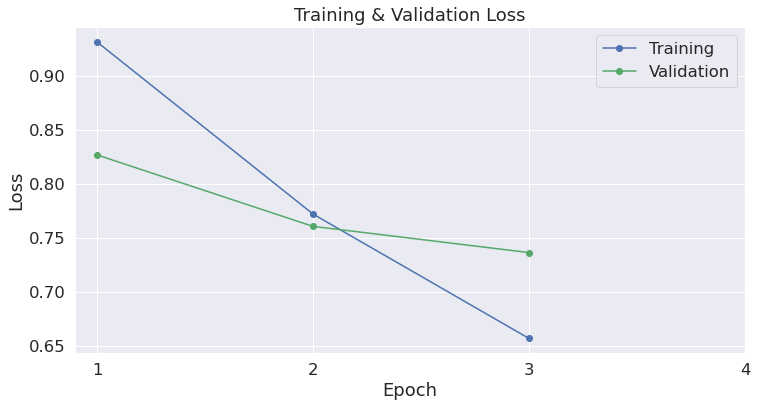

In [93]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [94]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 76 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072,

## Saving & Loading Fine-Tuned Model


In [95]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

#output_dir = './model_save/'
output_dir = './model_moi'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
#tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_moi


In [96]:
output_dir ='./model_moi'

model.save_pretrained(output_dir)

In [97]:
export_path = './model_moi'
torch.save(model, f'{export_path}/gpt2_v2.pt')
tokenizer.save_pretrained(export_path)

('./model_moi/tokenizer_config.json',
 './model_moi/special_tokens_map.json',
 './model_moi/vocab.json',
 './model_moi/merges.txt',
 './model_moi/added_tokens.json')

# Generate Text

In [10]:
# Load a trained model and vocabulary that you have fine-tuned
model_dump_dir = "./model_moi_big"
model = GPT2LMHeadModel.from_pretrained(model_dump_dir)
tokenizer = GPT2Tokenizer.from_pretrained(model_dump_dir)
device = torch.device("cuda")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [11]:
#test on sample question
model.eval()
input_prompt = "What is (are) Breast Cancer ?"

prompt = f"\n<|startoftext|>[WP] {input_prompt} \n[RESPONSE]"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: 
[WP] What is (are) Breast Cancer? 
[RESPONSE]The breast is the gland below the nipple and in front of the rectum. There are two main types of breast cancer:  named after the number of ducts each time they are made in. The most common kind of breast cancer is called transgressive breast cancer.  Women may be embarrassed to speak with their doctor about whether they should have the duct tapeed or donated cord. Some women have problems paying attention to their breasts after childbirth.  Women are four times more likely than men to have a normal breast. A woman may think that she is having problems paying attention to the ducts in the pelvic area. If this happens, a woman may get a lump in the pelvic area.  When the ducts are completely cut (cleaved) or clipped, the doctor can remove the growth of cells that have formed in the tissues. This is called ductal carcinoma.  When the ducts are completely cut (cleaved) or canned, the surgeon may remove the growth of cells. This is called duc

In [9]:
import pandas as pd
import re

# Load the CSS dataset into a DataFrame
df = pd.read_csv('All-2479-Answers-retrieved-from-MedQuAD.csv')  # Replace 'your_dataset.csv' with the actual file name

# Create new columns for the extracted question and answer
df['Extracted_Question'] = ''
df['Extracted_Answer'] = ''

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Extract the question using regex
    question_match = re.search(r'Question: (.+)\n', row['Answer'], re.IGNORECASE)
    if question_match:
        question = question_match.group(1)
        df.at[index, 'Extracted_Question'] = question.strip()
    
    # Extract the answer using regex
    answer_match = re.search(r'Answer: (.+)', row['Answer'], re.IGNORECASE)
    if answer_match:
        answer = answer_match.group(1)
        df.at[index, 'Extracted_Answer'] = answer.strip()
        
        
# Save the updated DataFrame to a new dataset
df.to_csv('new_dataset.csv', index=False)  # Replace 'new_dataset.csv' with the desired file name


FileNotFoundError: [Errno 2] No such file or directory: 'All-2479-Answers-retrieved-from-MedQuAD.csv'

In [10]:
df_test = pd.read_csv('new_dataset.csv')

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2479 entries, 0 to 2478
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   AnswerID            2479 non-null   object
 1   Answer              2479 non-null   object
 2   Extracted_Question  2479 non-null   object
 3   Extracted_Answer    2479 non-null   object
dtypes: object(4)
memory usage: 77.6+ KB


In [12]:
import re
model.eval()

def generate_gpt(input):
  input_prompt = input

  prompt = f"\n<|startoftext|>[WP] {input_prompt} \n[RESPONSE]"
  #print(prompt)

  generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
  generated = generated.to(device)

  sample_outputs = model.generate(
                                  generated, 
                                  #bos_token_id=random.randint(1,30000),
                                  do_sample=True,   
                                  top_k=50, 
                                  max_length = 100,
                                  top_p=0.95, 
                                  num_return_sequences=1
                                  )
  #print(sample_outputs)
  generated_text = sample_outputs[0].tolist()  # Get the first element of the list
  ans = tokenizer.decode(generated_text, skip_special_tokens=True)
  response_match = re.search(r'\[RESPONSE\](.+)', ans, re.IGNORECASE)
  #print(ans)
  #print(sample_outputs)
  if response_match:
    response = response_match.group(1).strip()
    return response

In [17]:
#testing on medquad
df_test['Predictions']  = df_test['Extracted_Question'].apply(generate_gpt)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

In [16]:
#testing on iCliniq
test['Predictions']  = test['Question'].apply(generate_gpt)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati